In [1]:
import numpy as np
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

MTSUN_SI = 4.925490947641267e-06

In [2]:
NPTS_TRAPEZOID = int(1e5)
def S_h_aLIGO(f):
    """
    Calculate the spectral density S_n(f) for given frequency f.
    
    Parameters:
        f (float or numpy.ndarray): Frequency in Hz
        
    Returns:
        float or numpy.ndarray: Spectral density value(s)
    """
    # Constants
    S0 = 3e-48  # Hz^-1
    f0 = 70     # Hz
    
    # Handle scalar input or numpy array
    if np.isscalar(f):
        if f < 10:
            return float('inf')
        else:
            return S0 * ((f0/f)**4 + 2*(1 + (f**2/f0**2)))
    else:
        # Convert input to numpy array if it isn't already
        f = np.asarray(f)
        result = np.zeros_like(f, dtype=float)
        
        # Apply piecewise conditions
        mask_low = f < 10
        mask_high = f >= 10
        
        result[mask_low] = float('inf')
        result[mask_high] = S0 * ((f0/f[mask_high])**4 + 2*(1 + (f[mask_high]**2/f0**2)))
        
        return result

def S_h_DECIGO(filename):
    """
    Calculate the spectral density S_n(f) for given frequency f.
    
    Parameters:
        f (float or numpy.ndarray): Frequency in Hz
        
    Returns:
        float or numpy.ndarray: Spectral density value(s)
    """
    f, S = np.loadtxt(filename, unpack=True, skiprows=1)
    return interp1d(f, (S / np.sqrt(f)) ** 2, kind='linear', fill_value=np.inf, bounds_error=False)
    

def integrand(f, beta):
    return f**(-beta) / S_h(f)


def compute_f7_3(f_lower=10, f_upper=1000):
    f_arr = np.geomspace(f_lower, f_upper, NPTS_TRAPEZOID)
    integrand_arr = integrand(f_arr, 7 / 3)
    integral = trapezoid(integrand_arr, f_arr)
    return integral


def compute_fbar(beta, f_lower=10, f_upper=1000):
    f7_3 = compute_f7_3(f_lower, f_upper)
    f_arr = np.geomspace(f_lower, f_upper, NPTS_TRAPEZOID)
    integrand_arr = integrand(f_arr, beta)
    integral = trapezoid(integrand_arr, f_arr)
    return integral / f7_3


def compute_Delta(f_lower=10, f_upper=1000):
    f1_3_bar = compute_fbar(1 / 3, f_lower, f_upper)
    f4_3_bar = compute_fbar(4 / 3, f_lower, f_upper)
    f17_3_bar = compute_fbar(17 / 3, f_lower, f_upper)
    f4_bar = compute_fbar(4, f_lower, f_upper)
    f3_bar = compute_fbar(3, f_lower, f_upper)

    return (
        (f1_3_bar - f4_3_bar**2) * f17_3_bar
        - f1_3_bar * f4_bar**2
        + (2 * f4_bar * f4_3_bar - f3_bar) * f3_bar
    )


def compute_mc_err(rho=10, M=1, f_lower=10, f_upper=1000):
    Delta = compute_Delta(f_lower, f_upper)
    factor = 16384 / (25 * rho**2)
    M_hat = M  # Fiducial value for chirp mass in solar masses

    f1_3_bar = compute_fbar(1 / 3, f_lower, f_upper)
    f4_3_bar = compute_fbar(4 / 3, f_lower, f_upper)
    
    num =  (f1_3_bar - f4_3_bar**2)
    den = Delta
    
    frac_err_square = factor * num / den * (np.pi * M_hat * MTSUN_SI) ** (10 / 3)

    return np.sqrt(frac_err_square)

def duration_in_band(chirp_mass, f_lower, f_upper):
    return 1000 * chirp_mass ** (-5 / 3) * (f_lower ** (-8 / 3) - f_upper ** (-8 / 3)) / (10 ** (-8/3))

In [3]:
# Does this match CF94?

S_h = S_h_aLIGO
alpha_aLIGO = compute_mc_err(f_lower=10, f_upper=4400)
print(f"Our calculation gives alpha={alpha_aLIGO:.1e}. CF94 value alpha=1.2e-5.")

filename = "decihertz-noise-curves/decigoMueller.txt"
S_h = S_h_DECIGO(filename=filename)

for f_low in [1e-2, 5e-2, 1e-1]:
    """
    Compute alpha for DECIGO assuming different f_low values.
    This alpha is only valid for chirp mass greater than Mcut,
    where Mcut is set by demanding that the in-band duration
    is smaller than the observation time of DECIGO (typically 4 yr). 
    """
    f_upper = 5
    alpha_DECIGO = compute_mc_err(f_lower=f_low, f_upper=f_upper)
    in_band_duration = duration_in_band(1, f_low, f_upper)
    decigo_obs_time = 4  # yr
    yr_to_sec = 365.25 * 24 * 3600
    Mcut = (in_band_duration / decigo_obs_time / yr_to_sec) ** (3 / 5)
    print(
        f"alpha={alpha_DECIGO:.1e} for DECIGO assuming f_low={f_low:.1e} Hz. "
        f"Valid only for Mc > {Mcut:.1e} Msun assuming DECIGO observation time = {decigo_obs_time} yr."
    )

Our calculation gives alpha=1.2e-05. CF94 value alpha=1.2e-5.
alpha=1.3e-10 for DECIGO assuming f_low=1.0e-02 Hz. Valid only for Mc > 5.5e+01 Msun assuming DECIGO observation time = 4 yr.
alpha=6.8e-10 for DECIGO assuming f_low=5.0e-02 Hz. Valid only for Mc > 4.2e+00 Msun assuming DECIGO observation time = 4 yr.
alpha=2.1e-09 for DECIGO assuming f_low=1.0e-01 Hz. Valid only for Mc > 1.4e+00 Msun assuming DECIGO observation time = 4 yr.


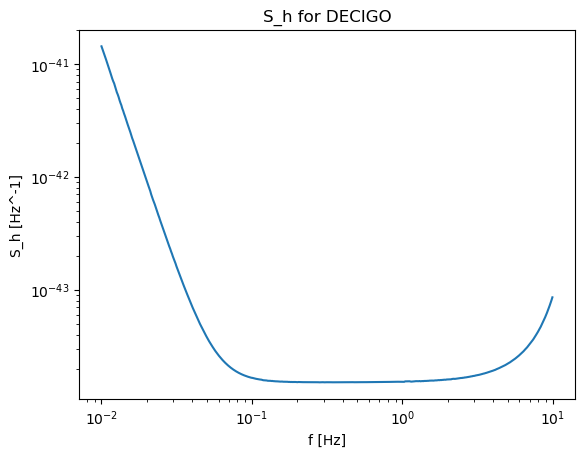

In [4]:
# plot S_h for DECIGO. This should have values <1e-40 Hz^-1 and
# a flat spectrum starting ~0.1 Hz if everything is correct.
f = np.geomspace(1e-2, 1e4, 1000)
plt.loglog(f, S_h(f))
plt.xlabel("f [Hz]")
plt.ylabel("S_h [Hz^-1]")
plt.title("S_h for DECIGO")
plt.show()